# Taskframe: Getting Started Tutorial

Welcome on this Demo notebook of Taskframe.ai, the annotation platform for data scientists. It allows you to set up data labelling projects and workflows for your Machine Learning projects. It supports a wide range of data formats (image, text, audio, etc.) and annotation types.

It was designed with the key following goals in mind:
* **Easy integration** with common data-science tools and workflows, in particular Jupyter Notebooks, Pandas, Pytorch, etc.
* **Easy Collaboration** to distribute annotation tasks to team members, perform reviews, provide feedback, etc.
* **Easy Customization** to adapt to any annotation task and create complex requirements.

Let's jump right into it.

## Set Up

First install the python lib and set your API key (found on your account page)

In [ ]:
!pip install taskframe

In [2]:
%load_ext autoreload
%autoreload 2
import os
import taskframe

In [28]:
taskframe.api_key = "xxxxx"

## The Taskframe Concept

The library and platform are built around a central datastructure called `Taskframe`. a *Taskframe* is simply a group of annotation tasks with the same parameters, by analogy with *Dataframes* commonly used in data-science and libraries such as Pandas. You can create your first Taskframe as follows:

In [29]:
tf = taskframe.Taskframe(
    data_type="image",
    task_type="classification",
    classes=["cat", "dog"]
)

Taskframes take a few common parameters:
  * `data_type`: the type of data that we are going to annotate, including `image`, `text`, `audio`, `html`, etc. In addition, the library also accepts a generic `iframe` data_type so you can submit custom and complex embeds.
  * `task_type`: the type of annotation to perform, including `classification`, `bounding_box`, etc.
  * `classes`: for classification tasks, we can simply pass the list of possible classes as a parameter
  
The full list of possible parameters are detailed in the [Documentation](https://github.com/Taskframe/taskframe-python/wiki).


You may preview the UI that workers will see with the `preview` method. This allows you to interactively configure your Taskframe settings from a Notebook environment.


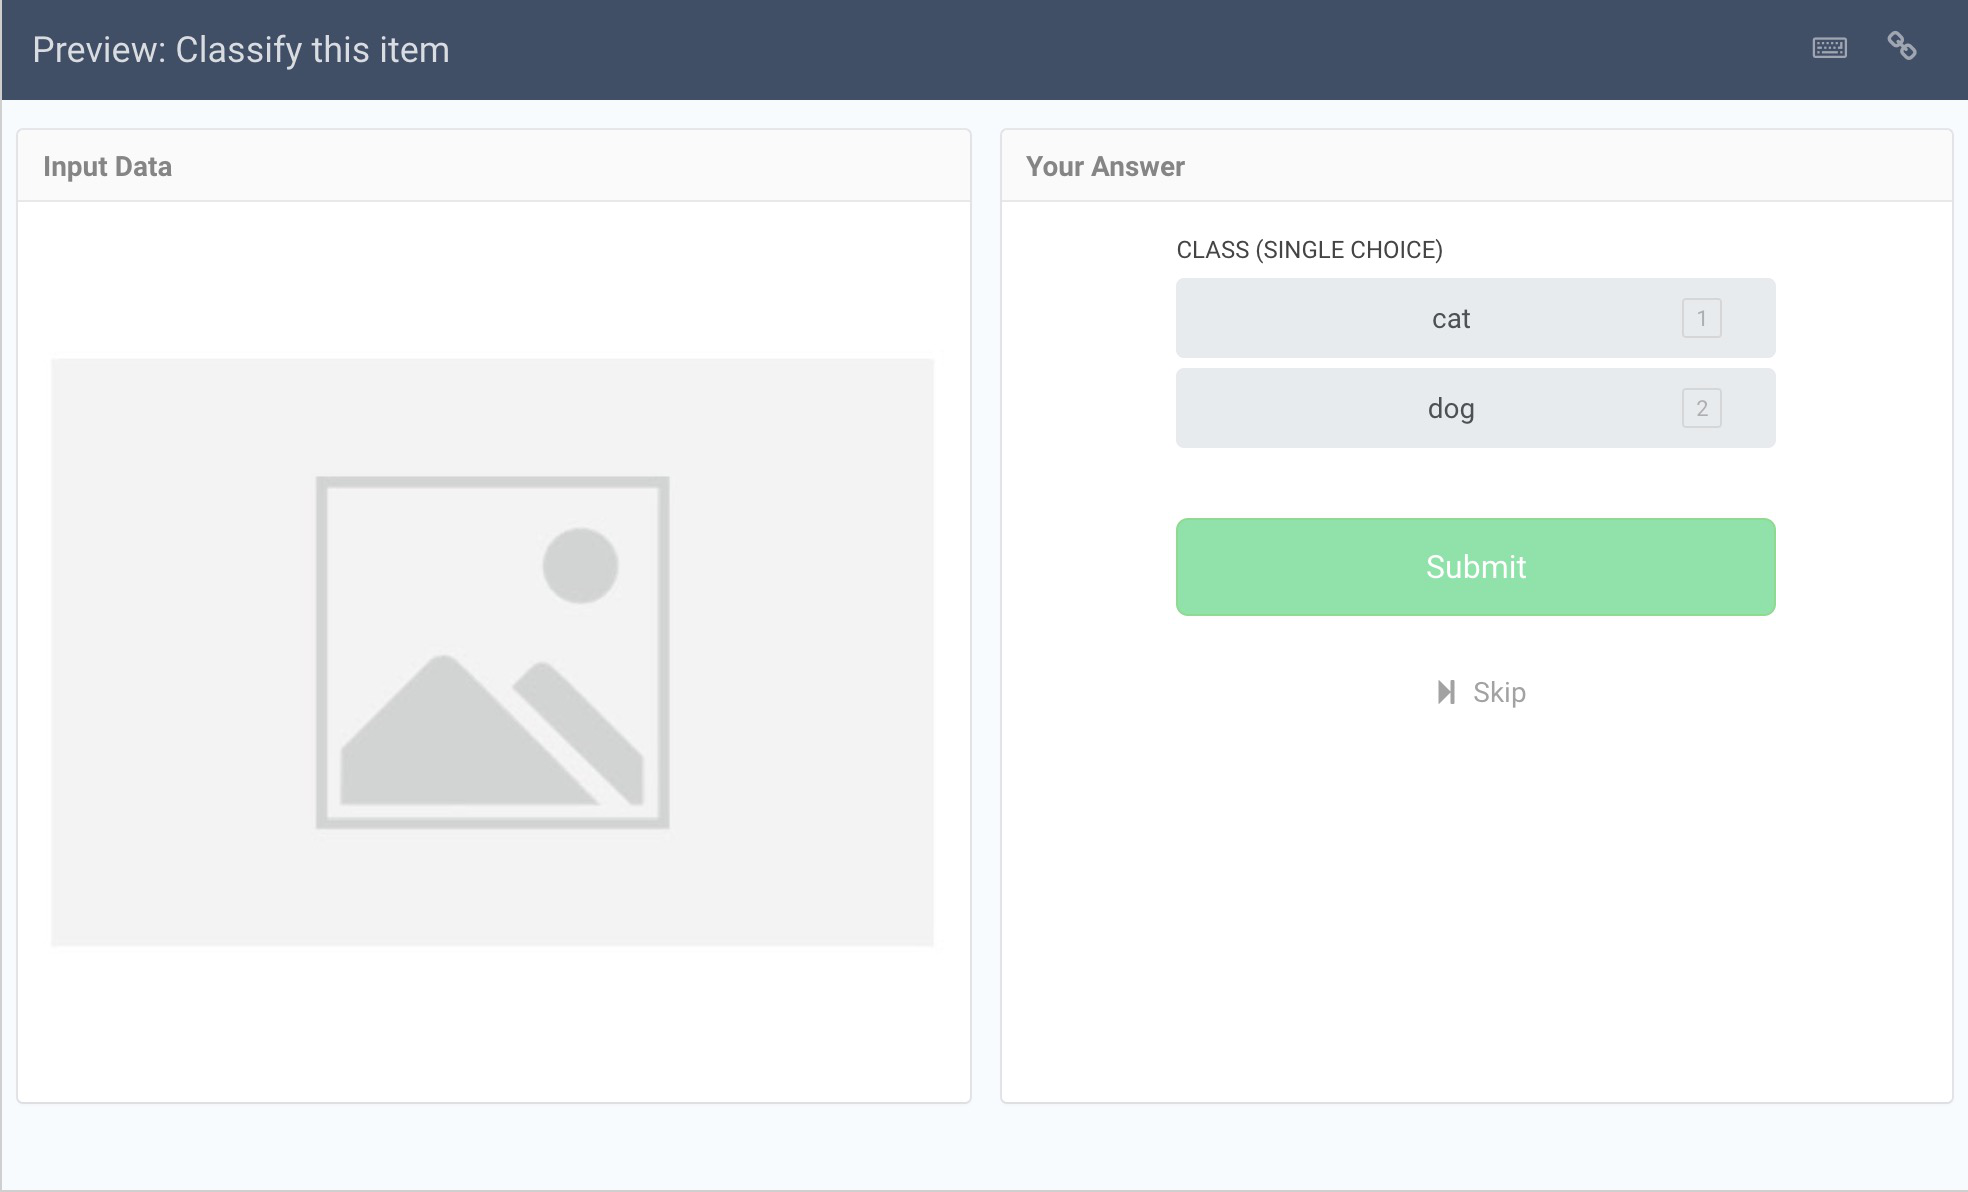

In [30]:
tf.preview()

Beyond the predefined task types, The `task_type="custom"` allows you to specify any task output. To do that, you just have to pass a standard [JSON Schema](https://json-schema.org/) dict in the `json_schema` parameter:

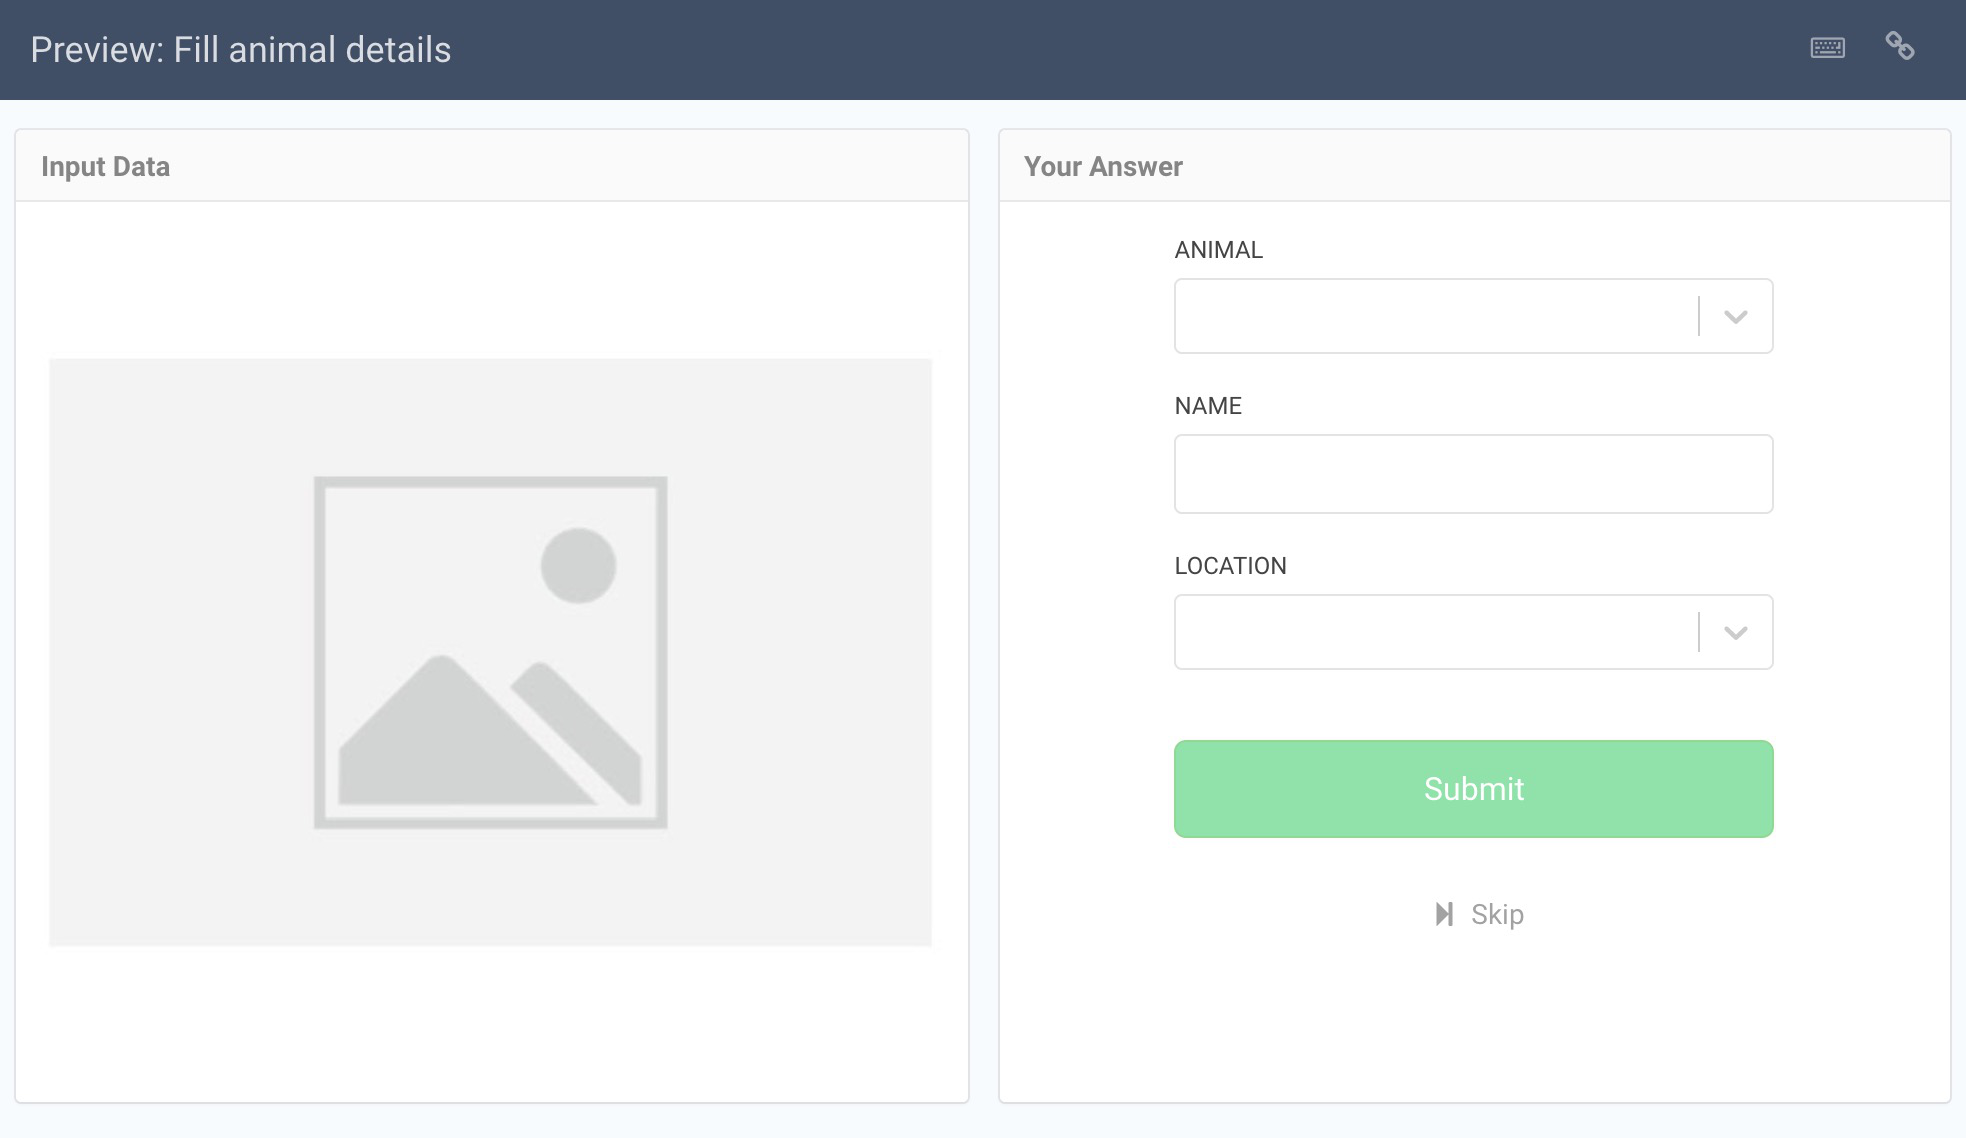

In [32]:
custom_tf = taskframe.Taskframe(
    data_type="image",
    task_type="custom",
    name="Fill animal details",
    json_schema={
        "type": "object",
        "properties": {
            "animal" : {
                "type": "string",
                "enum": ["cat", "dog"]
            },
            "name": {
                "type": "string"
            },
            "location": {
                "type": "string",
                "enum": ["city", "nature"]
            }
        }
    }
)
custom_tf.preview()

## Add a dataset
The next step is to add the data we need to annotate by attaching a `Dataset`. As in usual data science tools, a dataset is simply an iterable collection containing your data. The library offers several convenient methods to load them from different formats.

For example, let's say we have a Pandas dataframe with paths to local files:


In [22]:
import pandas
dataframe = pandas.read_csv('demo.csv')
dataframe[['path', 'identifier']].head()

,path,identifier
0,imgs/foo.jpg,foo
1,imgs/bar.jpg,bar


You can simply pass this dataframe to your taskframe with the dedicated method. you just have to specify the target column (where your data is) as a parameter :

In [23]:
tf.add_dataset_from_dataframe(dataframe, column="path")

If your dataset items have identifiers, you may pass them (by specifying the `custom_id_column`) to more easily retrieve results once it's done:

In [24]:
tf.add_dataset_from_dataframe(dataframe, column="path",custom_id_column="identifier")

Others methods to load a dataset include:
* `add_dataset_from_csv`
* `add_dataset_from_folder`
* `add_dataset_from_list`
* `add_dataset_from_tensor` (comming soon)

If you now call the `preview()` method, it will show the annotation interface with a random item from your dataset:

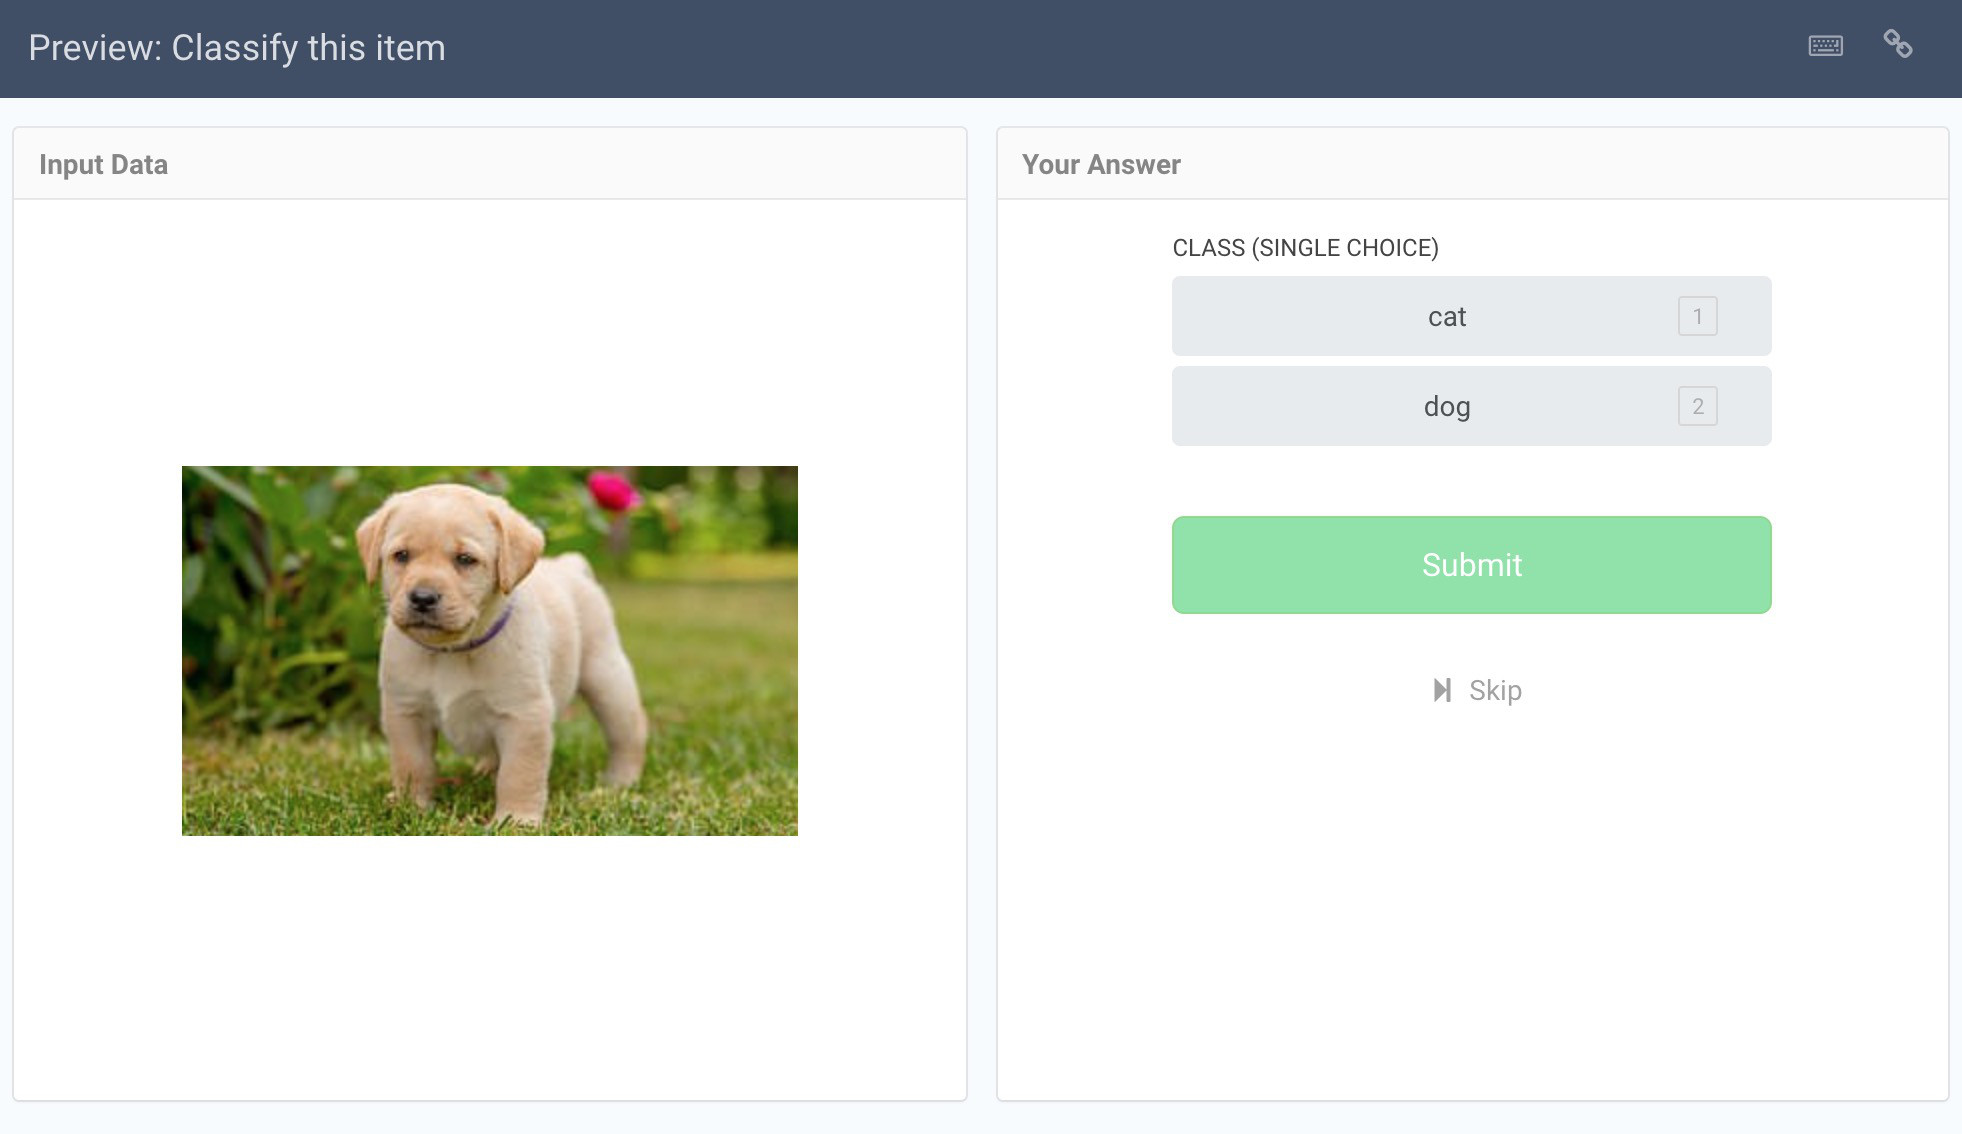

In [33]:
tf.preview()

### Dataset with pre-existing labels
if you provide a dataset with existing labels (for example computed from a machine learning model), the annotation form will be prefilled. Workers will be able to correct the label if necessary before submitting.

In [10]:
import pandas
dataframe = pandas.read_csv('demo.csv')
dataframe[['path', 'identifier', 'label']].head()

,path,identifier,label
0,imgs/foo.jpg,foo,dog
1,imgs/bar.jpg,bar,cat


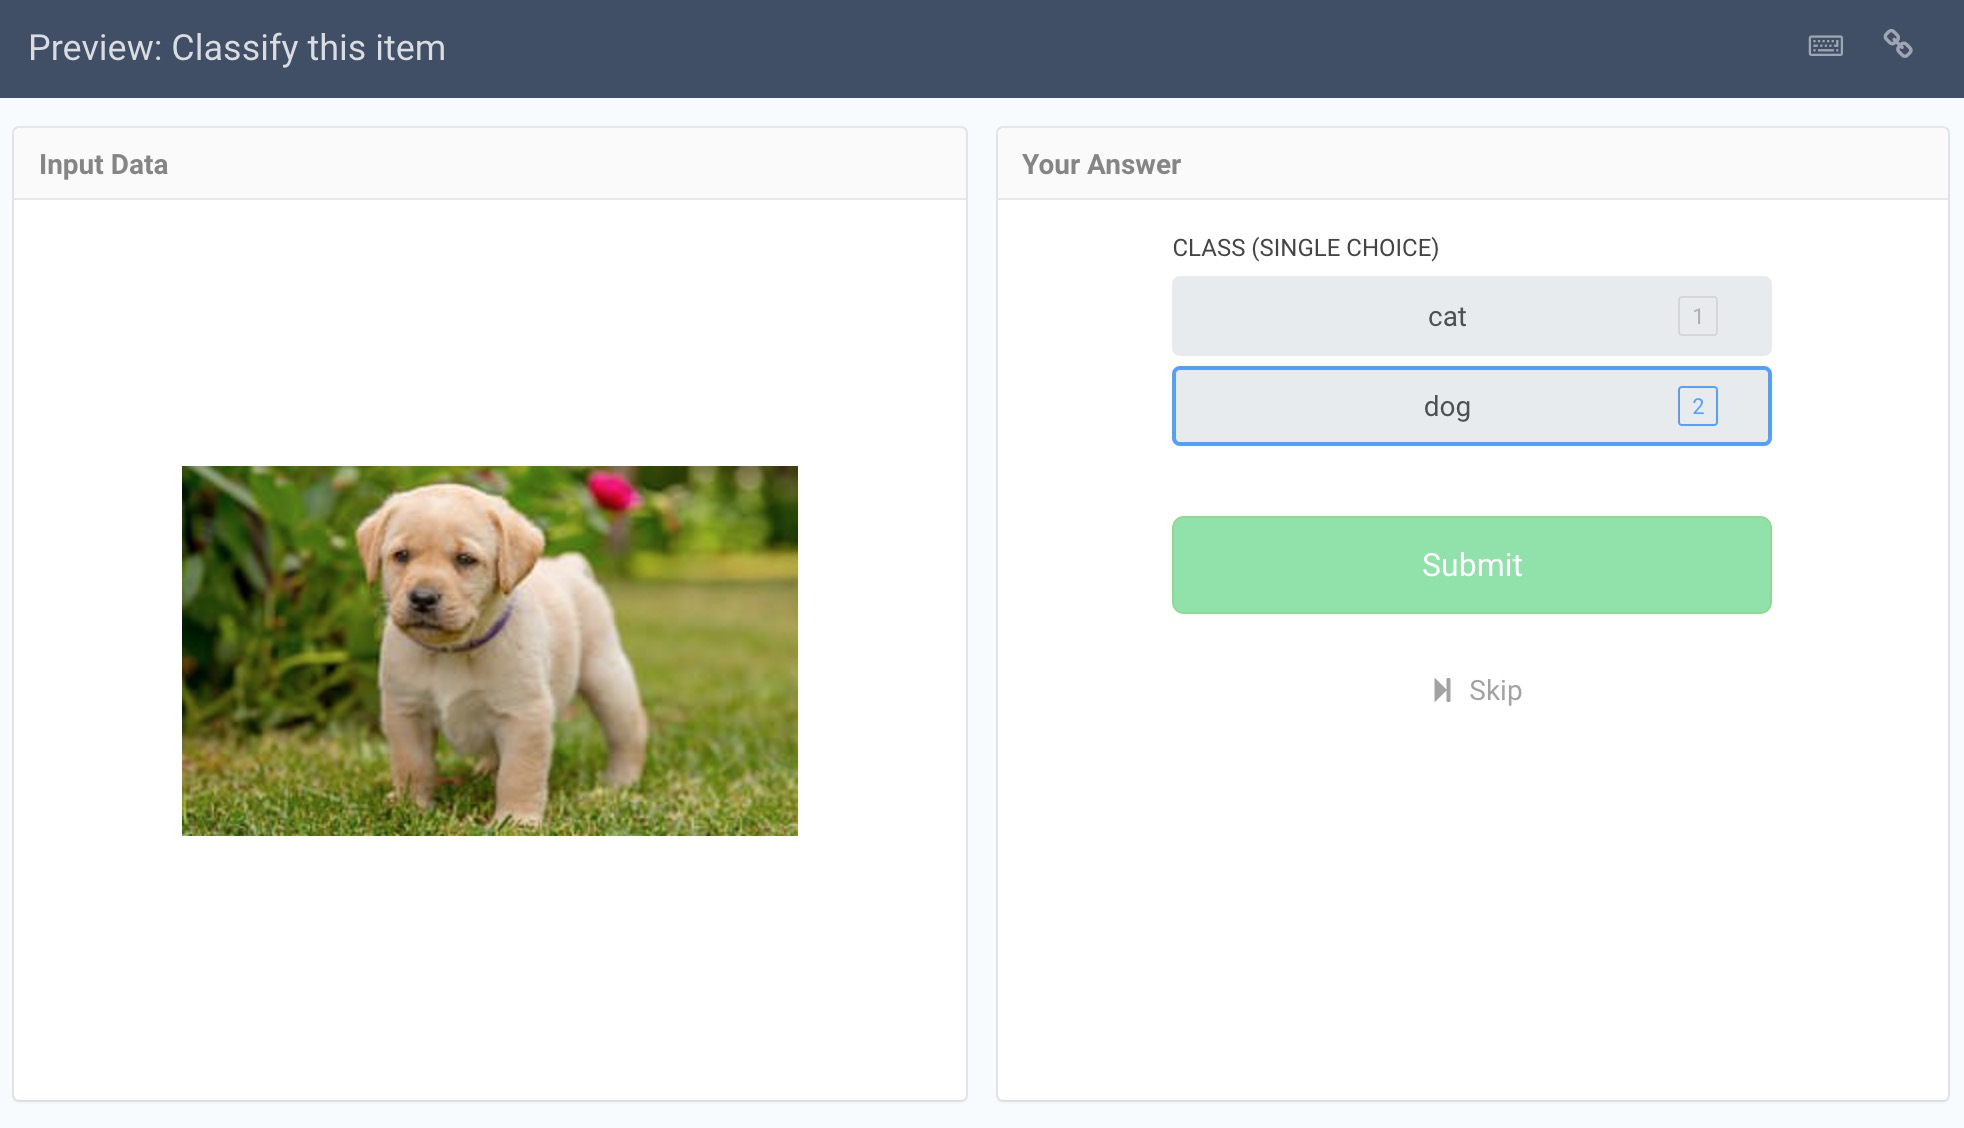

In [34]:
tf.add_dataset_from_dataframe(
    dataframe,
    column="path",
    label_column="label", # the column of the initial label
)
tf.preview()

## Adding a Training Set

Just like with Machine Learning training, you can include a training set to help your annotators get a better sense of the data and expected labels.

The training set is made of items for which you already have groundtruth labels. Your annotators will practice on the training set, and for each item they will see the expected label after submitting theirs.

Once they have gone trough the entire trainingset, they will be allowed to start labelling the actual dataset.

To do that, you may use similar methods as for adding a dataset, you just have to pass an additional parameter to specify the labels. For example with a dataframe:

In [35]:
training_dataframe = pandas.read_csv('demo.csv')
training_dataframe[['path', 'identifier', 'label']].head()

,path,identifier,label
0,imgs/foo.jpg,foo,dog
1,imgs/bar.jpg,bar,cat


In [36]:
tf.add_trainingset_from_dataframe(
    training_dataframe,
    column="path",
    label_column="label", # the column of the groundtruth label
)

## Invite Team Members

Now that your Taskframe is configured, it's time to specify the team members that will be invited to collaborate on the annotation tasks:

In [37]:
tf.add_team(
    workers=['mike@company.com', 'john@company.com'],
    reviewers=['dave@company.com']
)

There are 3 possible roles:
* `worker`: may only submit answers to tasks
* `reviewer`: may review answers from workers (and also submit answers themselves)
* `admin`: may change taskframe settings

## Submit

**Very Important**: the taskframe python client relies on "lazy" patterns: most methods and commands are usually not persisted to the platform. This allows you to interactively design and preview your taskframe and dataset in your Jupyter Notebook, before actually saving anything to the platform.

You have to call the `submit()` method to save your changes:

In [42]:
tf.submit()
print(f"Your taskframe_id: {tf.id}") # keep track if this id.

Your taskframe_id: xxxxxx


This will perform the following actions:
* Save the taskframe on the platform 
* Upload your dataset as new tasks
* Upload your trainingset if specified, and configure the training required score
* Send an email to team members to invite them to collaborate

## Fetching Results

Once your workers have submitted their answers and once reviewers have validated them, you can fetch your results:

In [ ]:
# Get the tf instance given its id 
tf = taskframe.Taskframe.retrieve("xxxxxx")

# Save labels as a csv (you need to pass the output path): 
tf.to_csv(path="output.csv")

# Save labels to a pandas dataframe:
df = tf.to_dataframe()

If your input dataset was already in a dataframe and you just want to insert the labels as a new column, you can do the following:

In [16]:
tf.merge_to_dataframe(dataframe, custom_id_column="identifier")

dataframe.head()

,idx,path,identifier,label
0,0,imgs/foo.jpg,foo,dog
1,1,imgs/bar.jpg,bar,cat


## Conclusion

That's it for a quick overview, feel free to explore the [Documentation](https://github.com/Taskframe/taskframe-python/wiki) (still work in progress) or check the source code.

Please let me know your feedback, suggestions and ideas to improve this library and associated platform !

# FIN